In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
# --- 1. SETUP & DATA LOADING ---
# Make sure these filenames match exactly what you uploaded

In [11]:
HGD_DIR = (Path.cwd() / ".." / "Structured Outputs" / "HGD").resolve()

try:
    df_regular = pd.read_csv(HGD_DIR / "base_hypergradient_results.csv")

    # handles filenames like "ablation_70_epochs_results (1).csv"
    ablation_csv = sorted(
        HGD_DIR.glob("ablation_*_epochs_results*.csv"),
        key=lambda p: p.stat().st_mtime,
        reverse=True
    )[0]
    df_ablation = pd.read_csv(ablation_csv)

    print("Files loaded successfully!")
    print("Regular:", HGD_DIR / "base_hypergradient_results.csv")
    print("Ablation:", ablation_csv)

except (FileNotFoundError, IndexError) as e:
    print(f"Error: {e}")
    print(f"Expected folder: {HGD_DIR}")


Files loaded successfully!
Regular: /Users/etaashpatel/Documents/Final Project/Structured Outputs/HGD/base_hypergradient_results.csv
Ablation: /Users/etaashpatel/Documents/Final Project/Structured Outputs/HGD/ablation_70_epochs_results (1).csv


In [12]:
# --- 2. DATA PROCESSING ---

# Process Regular HGD Data: Calculate Mean and Std Dev across seeds per Epoch
regular_grouped = df_regular.groupby('Epoch').agg({
    'Val_Acc': ['mean', 'std'],
    'LR': ['mean', 'std'],
    'WD': ['mean', 'std']
}).reset_index()

# Flatten the multi-level column names
regular_grouped.columns = ['Epoch', 'Val_Acc_mean', 'Val_Acc_std',
                           'LR_mean', 'LR_std', 'WD_mean', 'WD_std']

# Process Ablation Data: Group by HyperLR_Group and Epoch
ablation_grouped = df_ablation.groupby(['HyperLR_Group', 'Epoch'])['Val_Acc'].mean().reset_index()


Saved hgd_val_acc.png


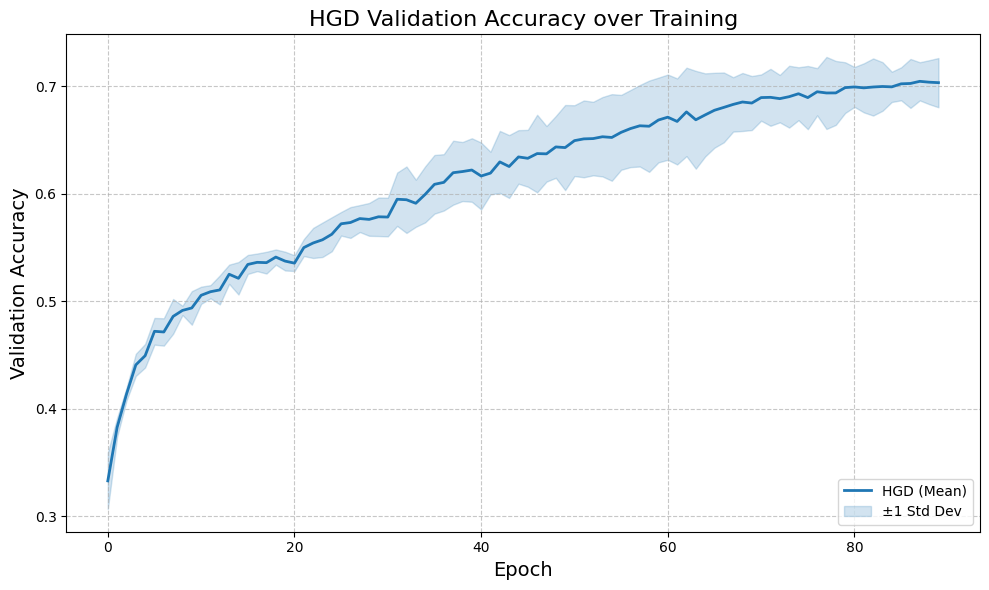

In [13]:
# --- 3. PLOT 1: HGD Validation Accuracy ---
plt.figure(figsize=(10, 6))

# Plot Mean line
plt.plot(regular_grouped['Epoch'], regular_grouped['Val_Acc_mean'],
         label='HGD (Mean)', color='#1f77b4', linewidth=2)

# Fill area for Standard Deviation
plt.fill_between(regular_grouped['Epoch'],
                 regular_grouped['Val_Acc_mean'] - regular_grouped['Val_Acc_std'],
                 regular_grouped['Val_Acc_mean'] + regular_grouped['Val_Acc_std'],
                 color='#1f77b4', alpha=0.2, label='±1 Std Dev')

plt.title('HGD Validation Accuracy over Training', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Validation Accuracy', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the plot
plt.savefig('hgd_val_acc.png', dpi=300)
print("Saved hgd_val_acc.png")
plt.show()




Saved hgd_hyperparams.png


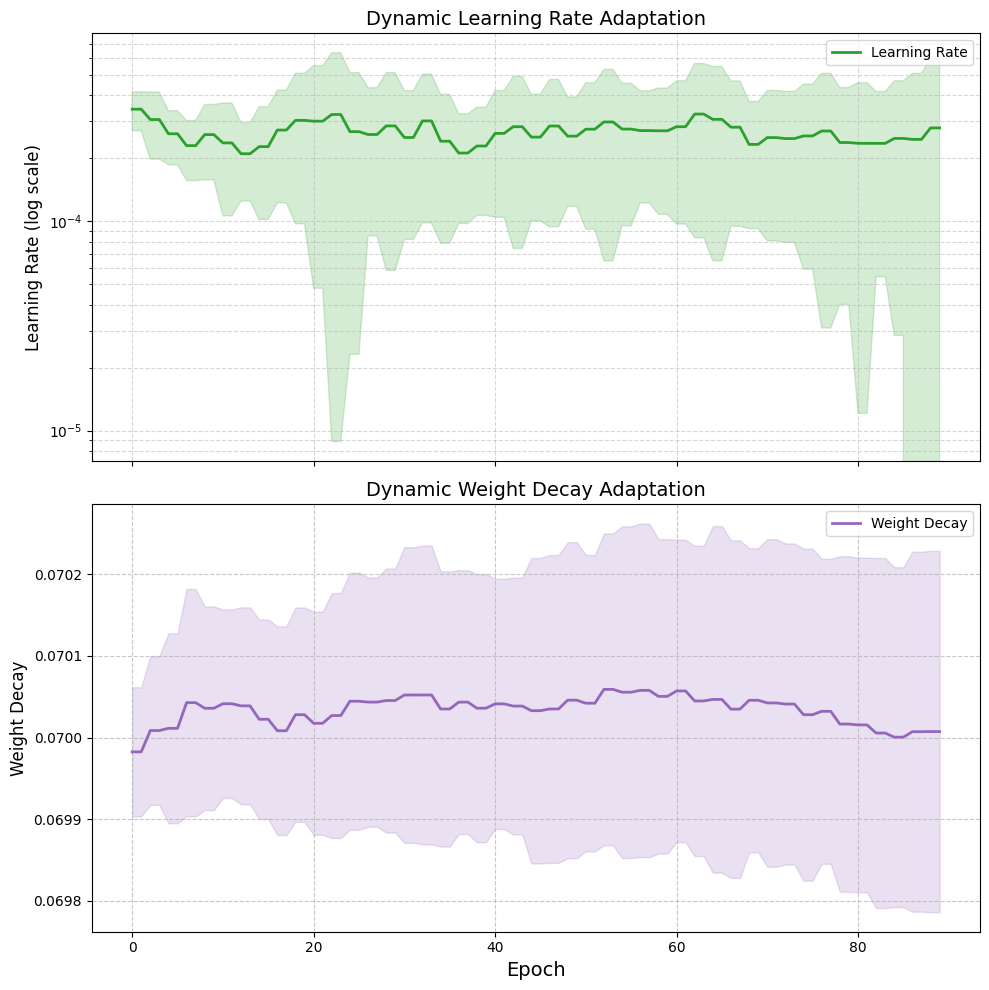

In [14]:
# --- 4. PLOT 2: Hyperparameter Evolution (LR & WD) ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Top Subplot: Learning Rate (Log Scale)
ax1.plot(regular_grouped['Epoch'], regular_grouped['LR_mean'],
         color='#2ca02c', label='Learning Rate', linewidth=2)
ax1.fill_between(regular_grouped['Epoch'],
                 regular_grouped['LR_mean'] - regular_grouped['LR_std'],
                 regular_grouped['LR_mean'] + regular_grouped['LR_std'],
                 color='#2ca02c', alpha=0.2)
ax1.set_title('Dynamic Learning Rate Adaptation', fontsize=14)
ax1.set_ylabel('Learning Rate (log scale)', fontsize=12)
ax1.set_yscale('log') # Important for LR!
ax1.grid(True, which="both", ls="--", alpha=0.5)
ax1.legend(loc='upper right')

# Bottom Subplot: Weight Decay
ax2.plot(regular_grouped['Epoch'], regular_grouped['WD_mean'],
         color='#9467bd', label='Weight Decay', linewidth=2)
ax2.fill_between(regular_grouped['Epoch'],
                 regular_grouped['WD_mean'] - regular_grouped['WD_std'],
                 regular_grouped['WD_mean'] + regular_grouped['WD_std'],
                 color='#9467bd', alpha=0.2)
ax2.set_title('Dynamic Weight Decay Adaptation', fontsize=14)
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Weight Decay', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig('hgd_hyperparams.png', dpi=300)
print("Saved hgd_hyperparams.png")
plt.show()


Saved ablation_hyperlr_4panel.png


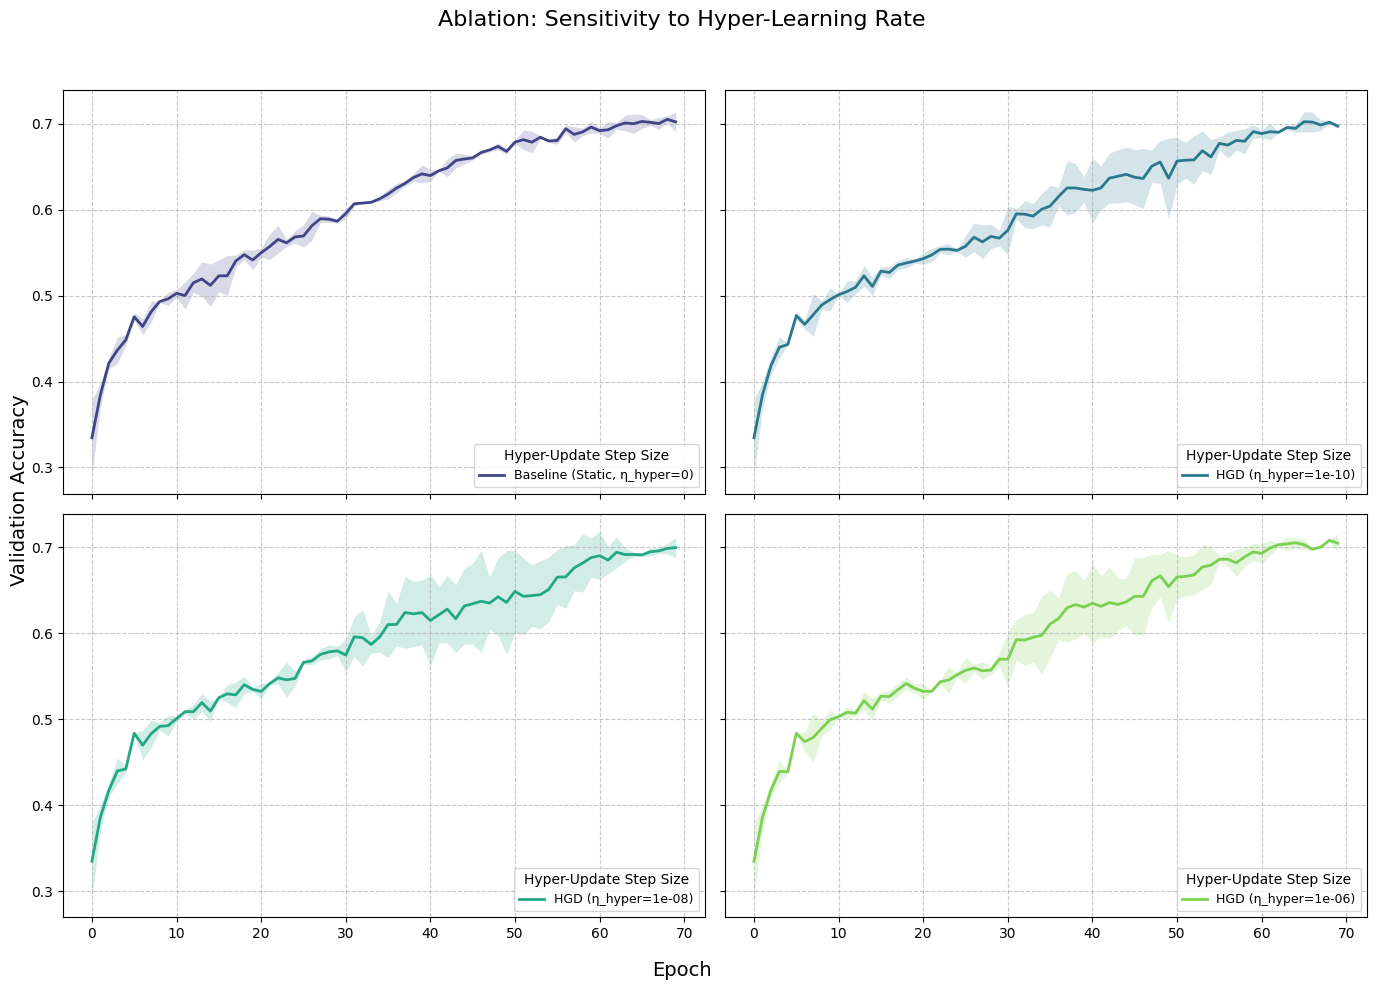

In [15]:
# --- 5. PLOT 3: Ablation Study (Hyper-LR Sensitivity) ---
ablation_grouped = (
    df_ablation
    .groupby(["HyperLR_Group", "Epoch"], as_index=False)
    .agg(
        Val_Acc_mean=("Val_Acc", "mean"),
        Val_Acc_std=("Val_Acc", "std"),
    )
)
ablation_grouped["Val_Acc_std"] = ablation_grouped["Val_Acc_std"].fillna(0.0)

# ---- plotting now starting ------#
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.ravel()

groups = sorted(ablation_grouped["HyperLR_Group"].unique())

palette = sns.color_palette("viridis", n_colors=len(groups))
color_map = {g: palette[i] for i, g in enumerate(groups)}

group_chunks = np.array_split(groups, 4)

band_alpha = 0.20  # increase/decrease to taste

for ax, chunk in zip(axes, group_chunks):
    for group in chunk:
        subset = (
            ablation_grouped[ablation_grouped["HyperLR_Group"] == group]
            .sort_values("Epoch")
        )

        if group == 0.0:
            label_text = "Baseline (Static, η_hyper=0)"
            line_style = "-"
        else:
            label_text = f"HGD (η_hyper={group})"
            line_style = "-"

        x = subset["Epoch"].to_numpy()
        y = subset["Val_Acc_mean"].to_numpy()
        s = subset["Val_Acc_std"].to_numpy()

        lower = y - s
        upper = y + s
        # optional if accuracy is in [0,1]:
        # lower = np.clip(lower, 0, 1)
        # upper = np.clip(upper, 0, 1)

        # Shaded ±1 std band
        ax.fill_between(
            x, lower, upper,
            color=color_map[group],
            alpha=band_alpha,
            linewidth=0,
            zorder=1
        )

        # Mean line (original style)
        ax.plot(
            x, y,
            label=label_text,
            color=color_map[group],
            linestyle=line_style,
            linewidth=2,
            zorder=2
        )

    ax.grid(True, linestyle="--", alpha=0.7)
    ax.legend(title="Hyper-Update Step Size", loc="lower right", fontsize=9)

fig.suptitle("Ablation: Sensitivity to Hyper-Learning Rate", fontsize=16)
fig.supxlabel("Epoch", fontsize=14)
fig.supylabel("Validation Accuracy", fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("ablation_hyperlr_4panel.png", dpi=300)
print("Saved ablation_hyperlr_4panel.png")
plt.show()


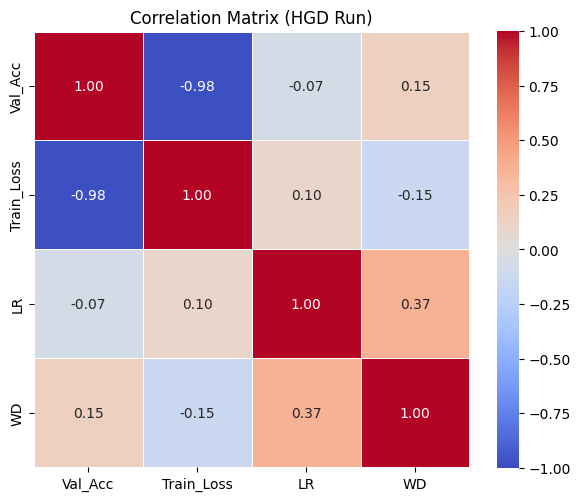

In [16]:
# Select only relevant numeric columns
cols_of_interest = ['Val_Acc', 'Train_Loss', 'LR', 'WD']
corr_matrix = df_regular[cols_of_interest].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmin=-1, vmax=1,
    square=True,
    linewidths=.5
)

plt.title('Correlation Matrix (HGD Run)')
plt.tight_layout()
plt.savefig('hgd_correlation_matrix.png', dpi=300)
plt.show()